In [173]:
import numpy as np

#extra imports
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

# Linear regression

Consider the following **linear equation:**

$$y_i = \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \epsilon_i$$

Assume you have access to data of the **independent variables** ($x_{1,i}$, $x_{2,i}$) and the **dependent variable** ($y_i$) for $N$ individuals, where $i$ indexes individuals. The variable $\epsilon_i$ is a mean-zero **stochastic shock**.

Assume the **data generating process** is given by:

In [2]:
def DGP(N):
    
    # a. independent variables
    x1 = np.random.normal(0,1,size=N)
    x2 = np.random.normal(0,1,size=N)
    
    # b. errors
    eps = np.random.normal(0,1,size=N)
    
    extreme = np.random.uniform(0,1,size=N)
    eps[extreme < 0.05] += np.random.normal(-5,1,size=N)[extreme < 0.05]
    eps[extreme > 0.95] += np.random.normal(5,1,size=N)[extreme > 0.95]
    
    # c. dependent variable
    y = 0.1 + 0.3*x1 + 0.5*x2 + eps
    
    return x1, x2, y

**The data you have access to is:**

In [3]:
np.random.seed(2020)
x1,x2,y = DGP(10000)

**Question 1:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **ordinary least squares (OLS)** implemented with **matrix algebra** by

$$ \hat{\mathbf{\beta}} = (\mathbf{X}^{\prime}\mathbf{X})^{-1}\mathbf{X}^{\prime}\mathbf{y} $$

where $\mathbf{X}^{\prime}$ is the transpose of $\mathbf{X}$ and

$$\mathbf{y} = 
\pmatrix{ y_1 \cr y_2 \cr  \vdots \cr y_N 
}
, \quad \mathbf{X} = \pmatrix{
1 & x_{1,1} & x_{2,1} \cr 
1 & x_{1,2} & x_{2,2} \cr 
\vdots & \vdots \cr 
1 & x_{1,N} & x_{2,N} 
}$$

In [21]:
# construct beta0 vector of ones
ones = np.ones(10000)

# construct X matrix
X_trans = np.array([ones,x1, x2])
X = X_trans.T

# set up equation and print answer
beta_hat = linalg.inv(X_trans@X)@X_trans@y
print('the estimate of beta is beta_hat =' + f' ({beta_hat[0]:.2f}, {beta_hat[1]:.2f}, {beta_hat[2]:.2f})')  

the estimate of beta is beta_hat = (0.10, 0.29, 0.50)


**Question 2:** Construct a 3D plot, where the data is plotted as scattered points, and the prediction of the model is given by the plane

$$\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_{1,i} + \hat{\beta}_2 x_{2,i}$$

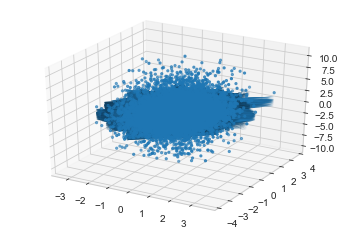

In [111]:
# predict y_hat
mesh1,mesh2 = np.meshgrid(x1,x2)
y_plane = beta_hat[0]+beta_hat[1]*mesh1+beta_hat[2]*mesh2

#print(y_plane.shape)
# plot the predictions vs. the data points
plt.style.use('seaborn-whitegrid')

fig_reg = plt.figure()
ax = fig_reg.add_subplot(1,1,1,projection='3d')
ax.scatter(x1,x2,y,s=5);
ax.plot_surface(x1,x2,y_plane);

**Question 3:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using a **numerical solver** to solve the ordinary least square problem, shown below, directly. Compare your results with the matrix algebra results.

$$ \min_{\mathbf{\beta}} \sum^N_{i=1} (y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) )^2 $$

In [94]:
def sum_of_squares(N,y,x1,x2,beta0,beta1,beta2):
    
    sum_of_sq = 0
    
    for i,j,k  in enumerate(y):
        ss = (y-(beta0+beta1*x1[i]+beta2*x2[i]))**2
        sum_of_sq += ss
    return sum_of_sq

def ssq_objective (N,y,x1,x2,beta):
    return sum_of_squares(N,y,x1,x2,beta0=beta0,beta1=beta1,beta2=beta2) 

In [95]:
beta_guess = [1,1,1]
N = 10000

ols = optimize.minimize(ssq_objective,x0=beta_guess,args=(N,y,x1,x2),method='Nelder-Mead')

beta_0 = ols.x[0]
beta_1 = ols.x[1]
beta_2 = ols.x[2]

print(beta_0, beta_1, beta_2)

TypeError: 'int' object is not iterable

<class 'numpy.ndarray'>


**Question 4:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **least absolute deviations (LAD)** using a numerical solver to solve the following problem directly: 

$$  \min_{\beta} \sum^N_{i=1} |y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) | $$

where $|z|$ is the absolute value of $z$.

**Question 5:** Set $N = 50$. Repeat the estimation using the **OLS** and **LAD** methods $K=5000$ times, drawing a new random sample from the data generating process each time. Compare the estimates from each method using histograms. Which method do you prefer? Explain your choice.

# Durable purchases

Consider a **household** living in two periods.

In the **second period** it gets utility from **non-durable consumption**, $c$, and **durable consumption**, $d+\chi x$:

$$
\begin{aligned}
v_{2}(m_{2},d)&= \max_{c}\frac{(c^{\alpha}(d+\chi x)^{1-\alpha})^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
x &= m_{2}-c \\
c &\in [0,m_{2}]
\end{aligned}
$$

where 

* $m_2$ is cash-on-hand in the beginning of period 2
* $c$ is non-durable consumption
* $d$ is pre-commited durable consumption
* $x = m_2 - c$ is extra durable consumption
* $\rho > 1$ is the risk aversion coefficient
* $\alpha \in (0,1)$ is the utility weight on non-durable consumption
* $\chi \in (0,1)$ implies that extra durable consumption is *less* valuable than pre-comitted durable consumption
* the second constraint ensures the household *cannot* die in debt

The **value function** $v_2(m_2,d)$ measures the household's value of having $m_2$ at the beginning of period 2 with precomitted durable consumption of $d$. The optimal choice of non-durable consumption is denoted $c^{\ast}(m_2,d)$. The optimal extra durable consumption function is $x^{\ast}(m_2,d) = m_2-c^{\ast}(m_2,d)$.

Define the so-called **end-of-period 1 value function** as:

$$
\begin{aligned}
w(a,d)&\equiv\beta\mathbb{E}_{1}\left[v_2(m_2,d)\right]
\end{aligned}
$$

where 

$$
\begin{aligned}
m_2&= (1+r)a+y \\
y &= \begin{cases}
1-\Delta & \text{with prob. }\frac{1}{3}\\
1 & \text{with prob. }\frac{1}{3}\\
1+\Delta & \text{with prob. }\frac{1}{3}
\end{cases}\\
\end{aligned}
$$

and

* $a$ is assets at the end of period 1
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $y$ is income in period 2
* $\Delta \in (0,1)$ is the level of income risk (mean-preserving)
* $r$ is the return on savings

In the **first period**, the household chooses it's pre-comitted level of durable consumption for the next-period,

$$
\begin{aligned}
v_{1}(m_{1})&=\max_{d} w(a,d)\\&\text{s.t.}&\\
a&= m_{1}-d \\
d&\in [0,m_{1}]\\
\end{aligned}
$$

where $m_1$ is cash-on-hand in period 1. The second constraint ensures the household *cannot* borrow. The **value function** $v_1(m_1)$ measures the household's value of having $m_1$ at the beginning of period 1. The optimal choice of pre-committed durable consumption is denoted $d^{\ast}(m_1)$.

The **parameters** and **grids** for $m_1$, $m_2$ and $d$ should be:

In [212]:
# a. parameters
rho = 2
alpha = 0.8
beta = 0.96
r = 0.04
Delta = 0.25
chi = 0.9

# b. grids
#m1_vec = np.linspace(1e-8,10,100)
#m2_vec = np.linspace(1e-8,10,100)
#d_vec = np.linspace(1e-8,5,100)

**Question 1:** Find and plot the functions $v_{2}(m_{2},d)$, $c^{\ast}(m_2,d)$, and $x^{\ast}(m_2,d)$. Comment.

In [168]:
# basic functions
def x(c,m2):
    return (m2-c)

def v2(c,m2,alpha,d,chi,rho):
    return (c**alpha*(d+chi*x(m2,c))**(1-alpha))**(1-rho)/(1-rho)

# solve period 2
def solve_p2(alpha,chi,rho):
    
    # grids
    m2_vec = np.linspace(1e-8,10,100)
    d_vec = np.linspace(1e-8,5,100)
    
    v2_grid = np.empty((100,100))
    c_grid = np.empty((100,100))
    x_grid = np.empty((100,100))
    
    # solve loop
    for i,m2 in enumerate(m2_vec):
        for j,d in enumerate(d_vec):
            
            # define objective
            obj = lambda c: -v2(c,m2,alpha,d,chi,rho)
            #constraint = ({'type':'eq', 'fun':lambda x: x-(m2-c)})
            
            # initial guess (consume a third)
            x0 = m2/3
            
            # optimize
            result = optimize.minimize_scalar(obj,x0,args=(alpha,d,chi,rho),method='bounded',bounds=[1e-8,m2])
            
            # save
            v2_grid[i,j] = -result.fun
            c_grid[i,j] = result.x
            x_grid[i,j] = m2 - result.x
            
    return m1_vec,m2_vec,v2_grid,c_grid,x_grid

In [213]:
# value function
def v2(c,m2,d,alpha,chi,rho):
    x = m2-c
    return (c**(alpha)*(d+chi*x)**(1-alpha))**(1-rho)/(1-rho)

The **solution function for period 2** is:

In [234]:
def solve_period_2(alpha,chi,rho):

    # a. grids
    m2_vec = np.linspace(1e-8,10,100)
    d_vec = np.linspace(1e-8,5,100)
    v2_grid = np.empty((100,100))
    c2_grid = np.empty((100,100))
    x_grid = np.empty((100,100))

    # b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):
        for j,d2 in enumerate(d2_vec):

            # i. objective
            obj = lambda c2: -v2(c2,d2,m2,alpha,chi,rho)

            # ii. initial value (consume third)
            x0 = m2/3

            # iii. optimizer
            result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m2])

            # iv. save
            v2_grid[i,j] = -result.fun
            c2_grid[i,j] = result.x
            x_grid[i,j] = m2-result.x
        
    return m2_vec,d_vec,v2_grid,c2_grid,x_grid

Now we can use the solution function to plot the functions:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

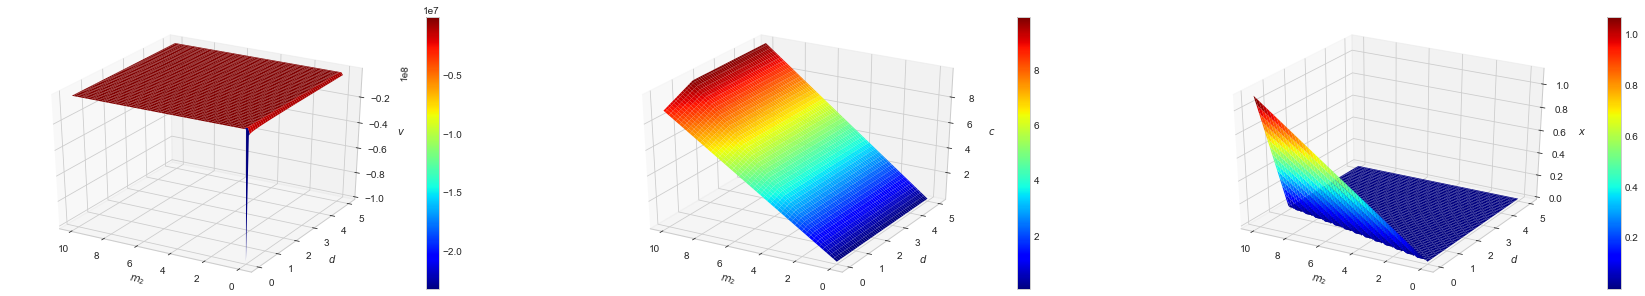

In [237]:
# a. solve
m2_vec,d_vec,v2_grid,c2_grid,x_grid = solve_period_2(alpha,chi,rho)

# b. grids
m2_grid,d_grid = np.meshgrid(m2_vec,d_vec,indexing='ij')

# c. main
fig = plt.figure(figsize=(30,5))
ax = fig.add_subplot(1,3,1,projection='3d')
cs = ax.plot_surface(m2_grid,d_grid,v2_grid,cmap=cm.jet)

# d. add labels
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$v$')

# e. invert xaxis
ax.invert_xaxis()

# f. add colorbar
fig.colorbar(cs);

ax = fig.add_subplot(1,3,2,projection='3d')
cs = ax.plot_surface(m2_grid,d_grid,c2_grid,cmap=cm.jet)

# d. add labels
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$c$')

# e. invert xaxis
ax.invert_xaxis()

# f. add colorbar
fig.colorbar(cs);

ax = fig.add_subplot(1,3,3,projection='3d')
cs = ax.plot_surface(m2_grid,d_grid,x_grid,cmap=cm.jet)

# d. add labels
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$x$')

# e. invert xaxis
ax.invert_xaxis()

# f. add colorbar
fig.colorbar(cs);

**Comment:** We see from the plof of $x$ that for extra durable good consumption to be positive, the consumer must have a relatively high amount of cash on hand and/or a relatively low amount of initial durable good consumption. This makes good sense, as the marginal utility from consumption in period 2 ($\alpha=0.8)$ is considerably higher than the marginal utility of durable good consumption ($1-alpha=0.2$). The kink in the x function is, in a sense, mirrored in the consumption function, as the consumer for a relatively high amount of $d$ spends its full cash endowment on consumption.

The plot of $v$ is not that easy to interpret. This is due to a property of the utility function (more precisely the "Cobb-Douglas part"), which tends towards negative infinity for very low values of $d$ and $m_2$. Hence, it is difficult to see that there actually is a change in the dark red area as it appears flat. One workaround is to adjust the starting point of the `np.linspace()` vectors, such that  values very close to zero are excluded. We do this below. 

In [233]:
np.allclose(m2_vec[99],c2_grid[99,50])

True

**Question 2:** Find and plot the functions $v_{1}(m_{1})$ and $d^{\ast}(m_1)$. Comment.

**Hint:** For interpolation of $v_2(m_2,d)$ consider using `interpolate.RegularGridInterpolator([GRID-VECTOR1,GRID-VECTOR2],VALUE-MATRIX,bounds_error=False,fill_value=None)`.

Next, consider an **extension** of the model, where there is also a **period 0**. In this period, the household makes a choice whether to stick with the level of durables it has, $z = 0$, or adjust its stock of durables, $z = 1$. If adjusting, the household loses a part of the value of its durable stock; more specificaly it incurs a proportional loss of $\Lambda \in (0,1)$.

Mathematically, the **household problem in period 0** is:

$$
\begin{aligned}
v_{0}(m_{0},d_{0}) &= \max_{z\in\{0,1\}} \begin{cases}
w(m_{0},d_{0}) & \text{if } z = 0\\
v_1(m_0+(1-\Lambda) d_{0}) & \text{if } z = 1\\
\end{cases}\\
\end{aligned}
$$

The **parameters** and **grids** for $m_0$ and $d_0$ should be:

In [5]:
Lambda = 0.2
m0_vec = np.linspace(1e-8,6,100)
d0_vec = np.linspace(1e-8,3,100)

**Question 3:** For which values of $m_0$ and  $d_0$ is the optimal choice not to adjust, i.e. $z = 0$? Show this in a plot. Give an interpretion of your results.

# Gradient descent

Let $\boldsymbol{x} = \left[\begin{array}{c}
x_1 \\
x_2\\
\end{array}\right]$ be a two-dimensional vector. Consider the following algorithm:

**Algorithm:** `gradient_descent()`

**Goal:** Minimize the function $f(\boldsymbol{x})$.

1. Choose a tolerance $\epsilon>0$, a scale factor $ \Theta > 0$, and a small number $\Delta > 0$
2. Guess on $\boldsymbol{x}_0$ and set $n=1$
3. Compute a numerical approximation of the jacobian for $f$ by

    $$
    \nabla f(\boldsymbol{x}_{n-1}) \approx \frac{1}{\Delta}\left[\begin{array}{c}
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    \Delta\\
    0
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})\\
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    0\\
    \Delta
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})
    \end{array}\right]
    $$

4. Stop if the maximum element in $|\nabla f(\boldsymbol{x}_{n-1})|$ is less than $\epsilon$
5. Set $\theta = \Theta$ 
6. Compute $f^{\theta}_{n} = f(\boldsymbol{x}_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1}))$
7. If $f^{\theta}_{n} < f(\boldsymbol{x}_{n-1})$ continue to step 9
8. Set $\theta = \frac{\theta}{2}$ and return to step 6     
9. Set $x_{n} = x_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1})$
10. Set $n = n + 1$ and return to step 3

**Question:** Implement the algorithm above such that the code below can run.

**Optimizer function:**

In [118]:
def gradient_descent(f,x0,epsilon=1e-6,Theta=0.1,Delta=1e-8,max_iter=1000): #eps is tolerance, Delta is small number, Theta is scale factor ## HUSK ÆNDRE MAX ITER tilbage til 10k ##
    
    # step 1
    x = x0 # guess
    fx = f(x0[0],x0[1])
    it = 1 # iterations
    
    # step 3-10
    while it < max_iter:
        
        xprev = x
        fxprev = fx
    
        # step 3: compute numerical jacobian
        jac_array = np.array([f(x[0]+Delta,x[1])-f(x[0],x[1])],[f(x[0],x[1]+Delta)-f(x[0],x[1])])
        num_jacx = 1/Delta*jac_array
        
        # step 4: check convergence
        if abs(np.max(jacarray)) < epsilon:
            break
            
        elif:
            # step 5:
            theta = Theta

            # step 6: 
            f_theta = f(x[0]-theta*num_jacx[0],x[1]-theta*num_jacx[1])

            # step 7:
            elif f_theta < fx:
                # step 9: update guess
                x = xprev  - theta*num_jacx
        
            else:
                # step 8: update theta
                theta /= 2
        
        # step 10: 
        it += 1
    
    return x,it 

**Test case:**

In [120]:
def rosen(x):
    return (1.0-x[0])**2+2*(x[1]-x[0]**2)**2

x0 = np.array([1.1,1.1])
try:
    x,it = gradient_descent(rosen,x0)
    print(f'minimum found at ({x[0]:.4f},{x[1]:.4f}) after {it} iterations')
    assert np.allclose(x,[1,1])
except:
    print('not implemented yet')

not implemented yet
